# Decision making in dynamics.

This notebook explores causal inference in the context of decision making with dynamics. As our starting point, we use the lending simulator introduced in [Delayed Impact of Fair Machine Learning](https://arxiv.org/abs/1803.04383). 

To connect this simulator with causal inference, we exploit it's representation as a structural causal model introduced in [Causal Modeling for Fairness in Dynamical Systems](https://arxiv.org/abs/1909.09141). All of the interventions we consider, including the "credit bureau" intervention, were introduced by Creager et al. For more details, see

1. Creager, Elliot, et al. "Causal Modeling for Fairness in Dynamical Systems." arXiv preprint 1909.09141, 2019.

2. Liu, Lydia, et al. "Delayed Impact of Fair Machine Learning." International Conference on Machine Learning. 2018.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pylab as plt
from tqdm.auto import tqdm

import whynot as wn
import whynot.traceable_numpy as np

from whynot.simulators.lending.simulator import INV_CDFS, GROUP_SIZE_RATIO

For illustrative purposes, we show how to construct the credit bureau intervention from [Creager et al.](https://arxiv.org/abs/1909.09141) in WhyNot. The user writes a handful of small functions, each determining a different aspect of the causal experiment.

In [3]:
def sample_initial_states(rng):
    """Sample initial states used on FICO data. Each initial state corresponds to an agent."""
    group = int(rng.uniform() < GROUP_SIZE_RATIO[1])
    # Compute credit score via inverse CDF trick
    score = INV_CDFS[group](rng.uniform())
    return wn.lending.State(group=group, credit_score=score)

In [58]:
@wn.parameter(
    name="threshold_g0", default=550, description="Lending threshold for group 0")
@wn.parameter(
    name="threshold_g1", default=550, description="Lending threshold for group 1")
def construct_config(threshold_g0, threshold_g1):
    """Return the experimental config for runs without intervention"""
    # Each rollout is a single timestep and only the lending thresholds are varied.
    return wn.lending.Config(
        start_time=0, end_time=1, threshold_g0=threshold_g0, threshold_g1=threshold_g1
    )


In [59]:
def extract_outcomes(run):
    """Outcome is the score change Delta and the institutions profit after 1 step."""
    return [run.states[1].credit_score - run.states[0].credit_score, run.states[1].profits]

In [60]:
def creditscore_threshold(score):
    """Alternate credit bureau scoring policy."""
    return max(score, 600)

In [7]:
# Construct the experiment
CreditBureauExperiment = wn.DynamicsExperiment(
    name="CreditBureauExperiment",
    description="Intervention on the credit scoring mechanism.",
    simulator=wn.lending,
    simulator_config=construct_config,
    # Change the credit scoring mechanism on the first step.
    intervention=wn.lending.Intervention(credit_scorer=creditscore_threshold, time=0),
    state_sampler=sample_initial_states,
    # All units are treated
    propensity_scorer=1.0,
    outcome_extractor=extract_outcomes,
    # Only covariate is group membership
    covariate_builder=lambda run: run.initial_state.group,
)

Compute average score changes for the minority, as well as institutional profits, as the minority threshold
varies and the majority threshold is fixed.

In [8]:
minority_thresholds = list(range(300, 800, 10))

average_min_score_changes = []
average_inst_profits = []
for tau_0 in tqdm(minority_thresholds):
    # Run the experiment to generate the dataset
    dataset = CreditBureauExperiment.run(threshold_g0=tau_0, num_samples=1000, parallelize=True)    
    
    # Only consider score changes for the minority group
    minority_locs = dataset.covariates[:, 0] == 0
    minority_treated_locs = minority_locs & (dataset.treatments == 1)

    score_changes = dataset.outcomes[:, 0]
    minority_changes = score_changes[minority_treated_locs]
    average_min_score_changes.append(np.mean(minority_changes))
        
    # Report profits over the entire group
    ind_profits = dataset.outcomes[:, 1][dataset.treatments == 1]
    average_inst_profits.append(np.mean(ind_profits))

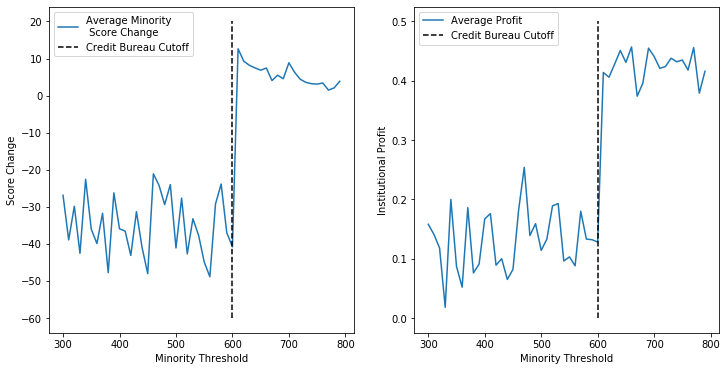

In [9]:
_, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(minority_thresholds, average_min_score_changes, label="Average Minority\n Score Change")
axs[0].plot([600] * 20, np.linspace(-60, 20, 20), label="Credit Bureau Cutoff", linestyle="--", color="black")
axs[0].legend()
axs[0].set_xlabel("Minority Threshold")
axs[0].set_ylabel("Score Change")
axs[1].plot(minority_thresholds, average_inst_profits, label="Average Profit")
axs[1].plot([600] * 20, np.linspace(0, 0.5, 20), label="Credit Bureau Cutoff", linestyle="--", color="black")
axs[1].set_xlabel("Minority Threshold")
axs[1].set_ylabel("Institutional Profit")
axs[1].legend();

# Causal Inference Example

Now, we slightly modify the CreditBureau example to show how WhyNot can also be used to address causal inference questions. Rather than treating all units or randomly assigning units to treatment (as in an RCT), suppose members of the minority group are more likely to receive the credit bureau intervention (75% chance) compared to members of the majority group (20% chance). Using this data, we wish to estimate the population-level causal effect of the credit intervention.


In [61]:
def propensity_scorer(untreated_run):
    """Assign minority to treatment 75% of the time, compared to 25% for the majority"""
    return  0.75 * (untreated_run.initial_state.group == 0) + 0.2 * (untreated_run.initial_state.group == 1)

In [86]:
# Construct the experiment
BiasedCreditBureauExperiment = wn.DynamicsExperiment(
    name="BiasedCreditBureauExperiment",
    description="Intervention on the credit scoring mechanism, with treatment bias.",
    simulator=wn.lending,
    simulator_config=construct_config,
    # Change the credit scoring mechanism on the first step.
    intervention=wn.lending.Intervention(credit_scorer=creditscore_threshold, time=0),
    state_sampler=sample_initial_states,
    propensity_scorer=propensity_scorer,
    outcome_extractor=extract_outcomes,
    # Only covariate is group membership, which is a confounder for this experiment.
    covariate_builder=lambda run: [run.initial_state.group, run.initial_state.credit_score]
)

Run the experiment to generate an observational dataset. Using `causal_graph=True` generates the causal graph associated with the experiment.

In [87]:
dataset = BiasedCreditBureauExperiment.run(num_samples=1000, causal_graph=True, show_progress=True)

In [88]:
# Inspect the causal graph
graph = dataset.causal_graph
print("## NODES ##")
for node in graph.nodes:
    print(node)
print("\n## EDGES ##\n")
for edge in graph.edges:
    print(edge)

## NODES ##
group_0
credit_score_0
profits_0
PARAM:credit_scorer_0
PARAM:threshold_g0_0
PARAM:threshold_g1_0
PARAM:repayment_utility_0
PARAM:default_utility_0
PARAM:repayment_score_change_0
PARAM:default_score_change_0
PARAM:min_score_0
PARAM:max_score_0
group_1
credit_score_1
profits_1
PARAM:credit_scorer_1
PARAM:threshold_g0_1
PARAM:threshold_g1_1
PARAM:repayment_utility_1
PARAM:default_utility_1
PARAM:repayment_score_change_1
PARAM:default_score_change_1
PARAM:min_score_1
PARAM:max_score_1
Treatment
Outcome

## EDGES ##

('group_0', 'group_1')
('group_0', 'credit_score_1')
('group_0', 'profits_1')
('group_0', 'Treatment')
('credit_score_0', 'credit_score_1')
('credit_score_0', 'profits_1')
('credit_score_0', 'Outcome')
('profits_0', 'profits_1')
('PARAM:credit_scorer_0', 'credit_score_1')
('PARAM:credit_scorer_0', 'profits_1')
('PARAM:threshold_g0_0', 'credit_score_1')
('PARAM:threshold_g0_0', 'profits_1')
('PARAM:threshold_g1_0', 'credit_score_1')
('PARAM:threshold_g1_0', 'profits_

In [89]:
# Estimate treatment effects using a potential outcomes estimator
covariates, treatment, outcome = dataset.covariates, dataset.treatments, dataset.outcomes
score_changes = dataset.outcomes[:, 0]

inference_result = wn.algorithms.ols.estimate_treatment_effect(
    covariates, treatment, score_changes)

print("Estimated ATE: {:.2f} ({:.2f}, {:.2f})".format(inference_result.ate, *inference_result.ci))
print("True ATE: {:.2f}".format(np.mean(dataset.true_effects[:, 0])))

Estimated ATE: -7.02 (-17.85, 3.80)
True ATE: -14.04


In [91]:
# Convert the dataset into a pandas dataframe
import pandas as pd

data = np.concatenate([covariates, treatment.reshape(-1, 1), score_changes.reshape(-1, 1)], axis=1)
df = pd.DataFrame(data, columns=graph.graph["covariate_names"] + ["Treatment", "Score Change"])
df.head()

group_0  credit_score_0  Treatment  Score Change
0      1.0      744.117647        1.0     55.882353
1      1.0      591.145833        0.0     75.000000
2      1.0      486.923077        0.0      0.000000
3      1.0      438.888889        0.0      0.000000
4      1.0      570.312500        0.0   -150.000000

In [85]:
# (TODO): Use DoWhy to estimate effects graphically!

# TODO: Add more covariates to the dataset by changing the covariate_builder function.